Doublecheck that the steady states obtained using the MTT are equivalent to those obtained from the eigenvalues of the laplacian:

In [1]:
import sys
import numpy as np
sys.path.append("./bin")
import matplotlib.pyplot as plt
from scipy.linalg import null_space
from matplotlib import colors
import twoconf_x_P_higherac_3 #_2 recompiled in other mac

In [2]:
instance=twoconf_x_P_higherac_3.GRFCalculations_100_100_15() #the accuracy chosen here doesn't really matter if we just want to calculate the steady state, but if we wanted to use the function to check for monotonicity, then it would

In [3]:
def LGP(pars,x,P=1): #laplacian matrix, we always use P=1
    ax_0_0,ax_0_1,bx_x_0,bx_x_1,aP_0_0,aP_0_1,bP_P_0,bP_P_1,aP_x_0,aP_x_1,bP_xP_0,bP_xP_1,ax_P_0,ax_P_1,bx_xP_0,bx_xP_1,kopen0,kclose0,kopenx,kclosex,kopenP,kcloseP,kopenxP,kclosexP=pars
    L=np.array([
    [0,ax_0_0*x,aP_0_0*P,0,kopen0,0,0,0], #(i,j): transition from i to j
    [bx_x_0,0,0,aP_x_0*P,0,kopenx,0,0],
    [bP_P_0,0,0,ax_P_0*x,0,0,kopenP,0],
    [0,bP_xP_0,bx_xP_0,0,0,0,0,kopenxP],
    [kclose0,0,0,0,0,ax_0_1*x,aP_0_1*P,0],
    [0,kclosex,0,0,bx_x_1,0,0,aP_x_1*P],
    [0,0,kcloseP,0,bP_P_1,0,0,ax_P_1*x],
    [0,0,0,kclosexP,0,bP_xP_1,bx_xP_1,0]
    ])
    return L.transpose() #because it should be that (i,j) is transition from j to i

In [4]:
def getparset(pars):
    ax_0_0,bx_x_0,aP_0_0,bP_P_0,kopen0,kclose0,alpha,beta,gamma,w,kbx=pars
    
    ax_P_0=ax_0_0
    bx_xP_0=bx_x_0/w
    
    aP_x_0=aP_0_0
    bP_xP_0=bP_P_0/w
    
    
    ax_0_1=ax_0_0 #G on rate is the same in both conformations
    bx_x_1=bx_x_0*kbx
    aP_0_1=aP_0_0 #P on rate is the same
    bP_P_1=bP_P_0*beta #<1 #off-rate changes
    
    
    aP_x_1=aP_0_1
    bP_xP_1=bP_P_1/(w*gamma)
    
    ax_P_1=ax_0_1
    bx_xP_1=bx_x_1/(w*gamma)


    kopenx=alpha*kopen0 #>1
    kclosex=kclose0
    kopenP=kopen0
    kcloseP=kclose0*beta #<1
    kopenxP=kopenx
    #deltaG=kcloseG-kclose0
    #deltaP=kcloseP-kclose0
    kclosexP=kclose0*beta*gamma


    parset=[ax_0_0,ax_0_1,bx_x_0,bx_x_1,aP_0_0,aP_0_1,bP_P_0,bP_P_1,aP_x_0,aP_x_1,bP_xP_0,bP_xP_1,ax_P_0,ax_P_1,bx_xP_0,bx_xP_1,kopen0,kclose0,kopenx,kclosex,kopenP,kcloseP,kopenxP,kclosexP]
    return parset


def compute_ss_fromL(L):
    L_d=np.diag(np.sum(L,axis=0))
    L=L-L_d
    rhos=null_space(L) #column vector
    rhos=np.transpose(rhos)[0] #1 row
    ss=np.abs(rhos)/np.sum(np.abs(rhos)) #can be - when very close to 0
    return ss


def check_and_plot_parset(pars,qs,title=None,widerange=False,color="k",text=None,figname=None,P=1):
    if not widerange:
        xvals=np.logspace(-1.,1.,200)
    else:
        xvals=np.logspace(-3,3,1000)
    values=np.zeros(len(xvals))
    #accessibilities=np.zeros(len(xvals))
    xval=0
    parset=getparset(pars)
    
    L=LGP(parset,xval,P)
    Ps=compute_ss_fromL(L)
    expr0=qs[0]*Ps[2]+qs[1]*Ps[3]+qs[2]*Ps[6]+qs[3]*Ps[7]
    #acc0=np.sum(Ps[4:])
    print(expr0)
    
    ss_c=[]
    ss_p=[]
    instance.fill_num_den(np.concatenate((parset,qs)), np.array([0]))
    for x_,xval in enumerate(xvals):
        #parset=getparset(pars)
        L=LGP(parset,xval,P)
        Ps=compute_ss_fromL(L)
        #acc=np.sum(Ps[4:])
        expr=qs[0]*Ps[2]+qs[1]*Ps[3]+qs[2]*Ps[6]+qs[3]*Ps[7]
        values[x_]=expr/expr0
        #accessibilities[x_]=acc/acc0
        
        ss_c.append(instance.interfaceGRF(xval))
        ss_p.append(expr)
    ss_c=np.array(ss_c)
    ss_p=np.array(ss_p)
    print("the max difference between c code and python code is")
    print(np.max(np.abs(ss_c-ss_p)))
    ss_c=ss_c/expr0

    fig,ax=plt.subplots(1,1,figsize=(3,2.5))
    ax.plot(xvals,values,color=color)
    ax2=ax.twinx()
    ax2.plot(xvals,ss_c,linestyle=":",color="cyan")
    ax.set_xscale('log')
    ax.set_xlabel(r"log$_{10}$([$x$])",size=14)
    ax.set_ylabel('fold change',size=14)
    ax.axhline(y=1,linestyle="--",color="gray")
    ax2.axhline(y=1,linestyle="--",color="gray")
    if title is not None:
        ax.set_title(title)
    if text is not None:
        ax.text(0.8,0.8,text,transform=ax.transAxes)
    plt.tight_layout()
    plt.show()

In [5]:
kbx=1 #we consider x doesn't change binding in closed/open
ax=1
bx=1
aP_0_0=0.1
bP_P_0=100
kopen0=0.01
kclose0=0.5
beta=0.02
gamma=1

0.0019569471624266174
the max difference between c code and python code is
1.7069679003611782e-14


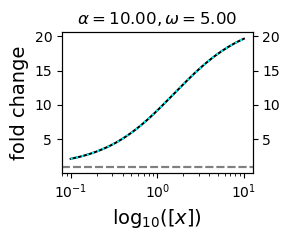

In [6]:
alpha=10
w=5
pars=np.array([ax,bx,aP_0_0,bP_P_0,kopen0,kclose0,alpha,beta,gamma,w,kbx])
qs=[1,1,1,1]
title=r"$\alpha=%2.2f,\omega=%2.2f$"%(alpha,w)
check_and_plot_parset(pars,qs,title=title,figname=None)

0.09882583170254403
the max difference between c code and python code is
2.3064883336587627e-14


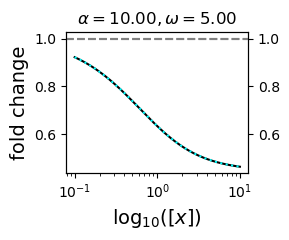

In [7]:
#notice that if expression from state 3 is much larger than from 4,7,8,then decreasing function.
alpha=10
w=5
pars=np.array([ax,bx,aP_0_0,bP_P_0,kopen0,kclose0,alpha,beta,gamma,w,kbx])
qs=[100,1,1,1]
title=r"$\alpha=%2.2f,\omega=%2.2f$"%(alpha,w)
check_and_plot_parset(pars,qs,title=title,figname=None)

0.09882583170254433
the max difference between c code and python code is
1.5690226895515025e-13


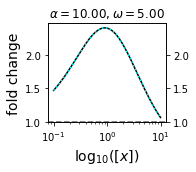

In [8]:
#and we can get nonmonotonicity if expression is very large from q7
alpha=10
w=5
pars=np.array([ax,bx,aP_0_0,bP_P_0,kopen0,kclose0,alpha,beta,gamma,w,kbx])
qs=[1,1,100,1]
title=r"$\alpha=%2.2f,\omega=%2.2f$"%(alpha,w)
check_and_plot_parset(pars,qs,title=title,figname=None)

0.19667318982387536
the max difference between c code and python code is
3.1386004906153175e-13


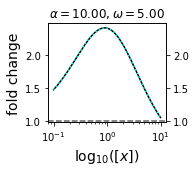

In [9]:
#and we can get nonmonotonicity if expression is very large from q7
alpha=10
w=5
pars=np.array([ax,bx,aP_0_0,bP_P_0,kopen0,kclose0,alpha,beta,gamma,w,kbx])
qs=[1,1,200,2]
title=r"$\alpha=%2.2f,\omega=%2.2f$"%(alpha,w)
check_and_plot_parset(pars,qs,title=title,figname=None)

Notice how the cyan and black lines overlap so the two codes give the same result.